# Coding Quiz 3

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import seaborn as sns
import statsmodels.api as sm

In [5]:
h31 = pd.read_csv('homework_3.1.csv')
h32a = pd.read_csv('homework_3.2.a.csv')
h32b = pd.read_csv('homework_3.2.b.csv')

In [6]:
h31

,time,value1,value2,value3
0,0,1.764052,1.883151,-0.369182
1,1,0.420157,-1.327759,-0.219379
2,2,1.018738,-1.230485,1.139660
3,3,2.300893,1.029397,0.715264
4,4,1.947558,-1.093123,0.720132
...,...,...,...,...
95,95,5.856573,3.628454,5.936891
96,96,5.230500,4.611791,4.937725
97,97,7.075870,4.703504,5.462954
98,98,5.486912,6.083236,4.520551


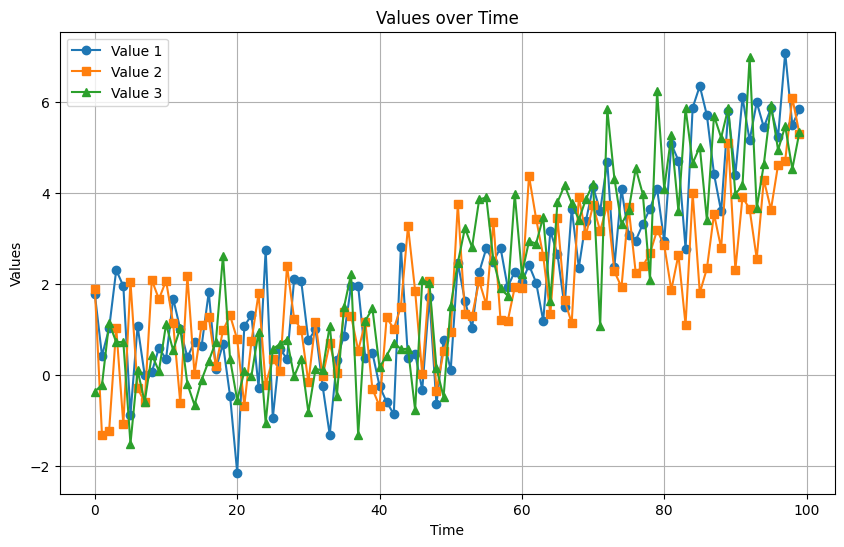

In [7]:
# Plot of value1, value2, and value3 over time
plt.figure(figsize=(10, 6))
plt.plot(h31['time'], h31['value1'], label='Value 1', marker='o')
plt.plot(h31['time'], h31['value2'], label='Value 2', marker='s')
plt.plot(h31['time'], h31['value3'], label='Value 3', marker='^')
plt.xlabel('Time')
plt.ylabel('Values')
plt.title('Values over Time')
plt.legend()
plt.grid()
plt.show()

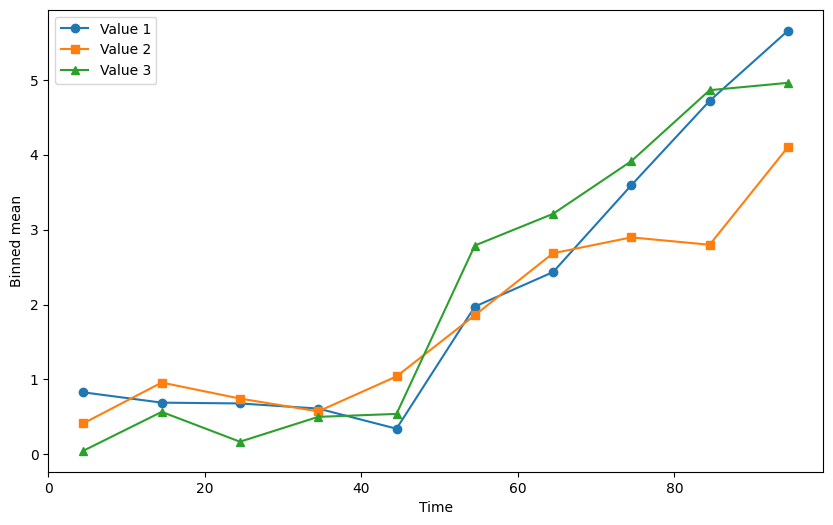

In [15]:
# Binning

bin_size = 10

# convert to numpy
time_array = h31["time"].to_numpy()
value1_array = h31["value1"].to_numpy()
value2_array = h31["value2"].to_numpy()
value3_array = h31["value3"].to_numpy()

# trim so length is divisible by bin_size
usable_length = len(time_array) - (len(time_array) % bin_size)
time_array = time_array[:usable_length]
value1_array = value1_array[:usable_length]
value2_array = value2_array[:usable_length]
value3_array = value3_array[:usable_length]

# bin means
time_binned = time_array.reshape(-1, bin_size).mean(axis=1)
value1_binned = value1_array.reshape(-1, bin_size).mean(axis=1)
value2_binned = value2_array.reshape(-1, bin_size).mean(axis=1)
value3_binned = value3_array.reshape(-1, bin_size).mean(axis=1)

# plot
plt.figure(figsize=(10, 6))
plt.plot(time_binned, value1_binned, label="Value 1", marker="o")
plt.plot(time_binned, value2_binned, label="Value 2", marker="s")
plt.plot(time_binned, value3_binned, label="Value 3", marker="^")
plt.xlabel("Time")
plt.ylabel("Binned mean")
plt.legend()
plt.show()


In [21]:
pd.set_option("display.float_format", lambda x: f"{x:.6f}")
np.set_printoptions(suppress=True)

# event setup
event_time = 50
h31["After"] = (h31["time"] >= event_time).astype(int)
h31["time_after"] = (h31["time"] - event_time) * h31["After"]

series_list = ["value1", "value2", "value3"]

# Test for a level jump at the event
level_rows = []
for s in series_list:
    y = h31[s].astype(float).to_numpy()
    X = pd.DataFrame({
        "time": h31["time"].astype(float).to_numpy(),
        "After": h31["After"].astype(float).to_numpy()
    })
    m = sm.OLS(y, sm.add_constant(X)).fit()
    level_rows.append({
        "series": s,
        "After_coef": float(m.params["After"]),
        "After_se": float(m.bse["After"]),
        "After_t": float(m.tvalues["After"]),
        "After_p": float(m.pvalues["After"])
    })

level_results = pd.DataFrame(level_rows)
level_results["abs_after_coef"] = level_results["After_coef"].abs()
level_sorted = level_results.sort_values(
    by=["After_p", "abs_after_coef"],
    ascending=[True, False]
).reset_index(drop=True)

# Q2: test for a slope change at the event
slope_rows = []
for s in series_list:
    y = h31[s].astype(float).to_numpy()
    X = pd.DataFrame({
        "time": h31["time"].astype(float).to_numpy(),
        "After": h31["After"].astype(float).to_numpy(),
        "time_after": h31["time_after"].astype(float).to_numpy()
    })
    m = sm.OLS(y, sm.add_constant(X)).fit()
    slope_rows.append({
        "series": s,
        "time_after_coef": float(m.params["time_after"]),
        "time_after_se": float(m.bse["time_after"]),
        "time_after_t": float(m.tvalues["time_after"]),
        "time_after_p": float(m.pvalues["time_after"])
    })

slope_results = pd.DataFrame(slope_rows)
slope_results["abs_time_after_coef"] = slope_results["time_after_coef"].abs()
slope_sorted = slope_results.sort_values(
    by=["time_after_p", "abs_time_after_coef"],
    ascending=[True, False]
).reset_index(drop=True)

# print tables and answers
print("=== Discontinuity in VALUE at time = 50 (value ~ const + time + After) ===")
print(level_sorted[["series", "After_coef", "After_se", "After_t", "After_p"]].to_string(index=False))
print(f"\nStrongest VALUE jump: {level_sorted.loc[0, 'series']}")

print("\n=== Discontinuity in SLOPE at time = 50 (value ~ const + time + After + time_after) ===")
print(slope_sorted[["series", "time_after_coef", "time_after_se", "time_after_t", "time_after_p"]].to_string(index=False))
print(f"\nStrongest SLOPE change: {slope_sorted.loc[0, 'series']}")

=== Discontinuity in VALUE at time = 50 (value ~ const + time + After) ===
series  After_coef  After_se  After_t  After_p
value3    1.767254  0.405625 4.356868 0.000033
value1    0.850813  0.489889 1.736745 0.085607
value2    0.682746  0.427019 1.598864 0.113103

Strongest VALUE jump: value3

=== Discontinuity in SLOPE at time = 50 (value ~ const + time + After + time_after) ===
series  time_after_coef  time_after_se  time_after_t  time_after_p
value1         0.105325       0.013246      7.951259      0.000000
value3         0.050695       0.013143      3.857133      0.000208
value2         0.036921       0.014385      2.566732      0.011811

Strongest SLOPE change: value1


In [22]:
h32a

,group1,time1,outcome1
0,0,0,0.882026
1,0,1,1.600079
2,0,0,0.489369
3,0,1,2.520447
4,0,0,0.933779
...,...,...,...
995,1,1,4.306435
996,1,0,1.900801
997,1,1,4.147096
998,1,0,1.426195


In [23]:
h32b

,group2,time2,outcome2
0,0,0,0.667155
1,0,1,2.470969
2,0,0,-0.506778
3,0,1,1.525657
4,0,0,0.273664
...,...,...,...
995,1,1,4.637301
996,1,0,3.681828
997,1,1,4.710121
998,1,0,0.629718


/var/folders/rv/ykggspv13l50b7nthk6kwm6r0000gn/T/ipykernel_1916/1834685742.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  h32a_control_before = h32a[h32a["group1"] == 0][h32a["time1"] == 0]
/var/folders/rv/ykggspv13l50b7nthk6kwm6r0000gn/T/ipykernel_1916/1834685742.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  h32a_control_after = h32a[h32a["group1"] == 0][h32a["time1"] == 1]
/var/folders/rv/ykggspv13l50b7nthk6kwm6r0000gn/T/ipykernel_1916/1834685742.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  h32a_treated_before = h32a[h32a["group1"] == 1][h32a["time1"] == 0]
/var/folders/rv/ykggspv13l50b7nthk6kwm6r0000gn/T/ipykernel_1916/1834685742.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  h32a_treated_after = h32a[h32a["group1"] == 1][h32a["time1"] == 1]
/var/folders/rv/ykggspv13l50b7nthk6kwm6r0000gn/T/ipykernel_1916/1834685742.py:5: UserWarning: 

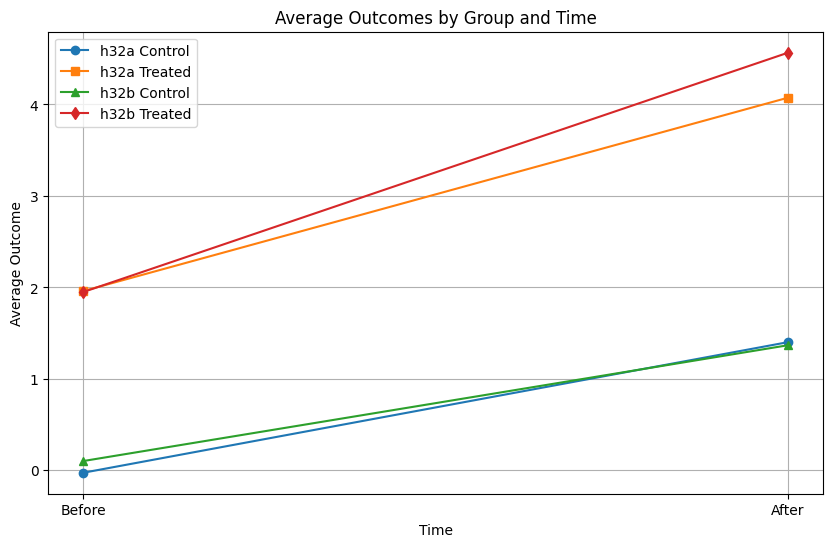

In [29]:
h32a_control_before = h32a[h32a["group1"] == 0][h32a["time1"] == 0]
h32a_control_after = h32a[h32a["group1"] == 0][h32a["time1"] == 1]
h32a_treated_before = h32a[h32a["group1"] == 1][h32a["time1"] == 0]
h32a_treated_after = h32a[h32a["group1"] == 1][h32a["time1"] == 1]
h32b_control_before = h32b[h32b["group2"] == 0][h32b["time2"] == 0]
h32b_control_after = h32b[h32b["group2"] == 0][h32b["time2"] == 1]
h32b_treated_before = h32b[h32b["group2"] == 1][h32b["time2"] == 0]
h32b_treated_after = h32b[h32b["group2"] == 1][h32b["time2"] == 1]

# Plot averages for each group and time
plt.figure(figsize=(10, 6))
plt.plot([0, 1], [h32a_control_before["outcome1"].mean(), h32a_control_after["outcome1"].mean()], label='h32a Control', marker='o')
plt.plot([0, 1], [h32a_treated_before["outcome1"].mean(), h32a_treated_after["outcome1"].mean()], label='h32a Treated', marker='s')
plt.plot([0, 1], [h32b_control_before["outcome2"].mean(), h32b_control_after["outcome2"].mean()], label='h32b Control', marker='^')
plt.plot([0, 1], [h32b_treated_before["outcome2"].mean(), h32b_treated_after["outcome2"].mean()], label='h32b Treated', marker='d')
plt.xlabel('Time')
plt.ylabel('Average Outcome')
plt.title('Average Outcomes by Group and Time')
plt.xticks([0, 1], ['Before', 'After'])
plt.legend()
plt.grid()
plt.show()

In [31]:
X1 = sm.add_constant(pd.DataFrame({
    "time1": h32a["time1"],
    "group1": h32a["group1"],
    "time1_group1": h32a["time1"] * h32a["group1"]
}))
y1 = h32a["outcome1"]
results1 = sm.OLS(y1, X1).fit()
X2 = sm.add_constant(pd.DataFrame({
    "time2": h32b["time2"],
    "group2": h32b["group2"],
    "time2_group2": h32b["time2"] * h32b["group2"]
}))
y2 = h32b["outcome2"]
results2 = sm.OLS(y2, X2).fit()

print("=== h32a Regression Results ===")
print(results1.params)
print("\n=== h32b Regression Results ===")
print(results2.params)


=== h32a Regression Results ===
const          -0.025849
time1           1.427213
group1          1.986278
time1_group1    0.685847
dtype: float64

=== h32b Regression Results ===
const          0.102107
time2          1.265513
group2         1.847719
time2_group2   1.349859
dtype: float64


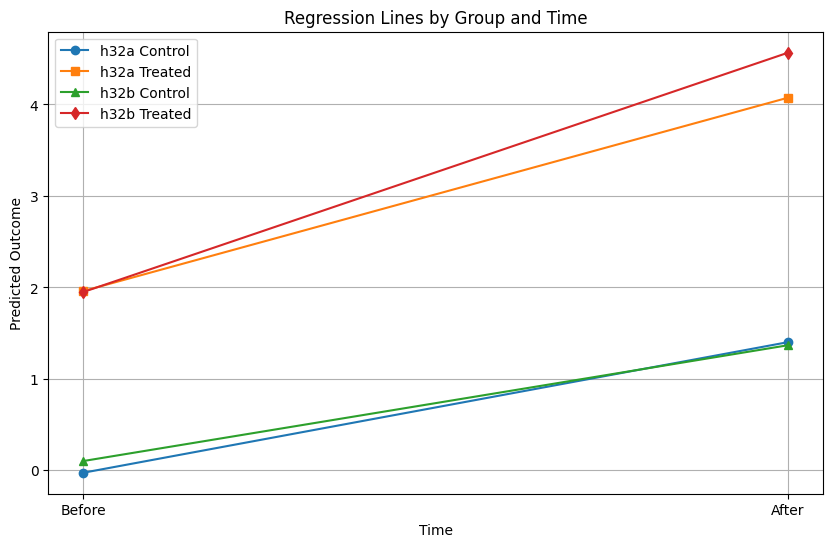

In [32]:
# Plot regression lines
plt.figure(figsize=(10, 6))
# h32a control
plt.plot([0, 1], [results1.params['const'], results1.params['const'] + results1.params['time1']], label='h32a Control', marker='o')
# h32a treated
plt.plot([0, 1], [results1.params['const'] + results1.params['group1'], 
                   results1.params['const'] + results1.params['time1']
                     + results1.params['group1'] + results1.params['time1_group1']], label='h32a Treated', marker='s')
# h32b control
plt.plot([0, 1], [results2.params['const'], results2.params['const'] + results2.params['time2']], label='h32b Control', marker='^')
# h32b treated
plt.plot([0, 1], [results2.params['const'] + results2.params['group2'], 
                   results2.params['const'] + results2.params['time2']
                     + results2.params['group2'] + results2.params['time2_group2']], label='h32b Treated', marker='d')
plt.xlabel('Time')
plt.ylabel('Predicted Outcome')
plt.title('Regression Lines by Group and Time')
plt.xticks([0, 1], ['Before', 'After'])
plt.legend()
plt.grid()
plt.show()

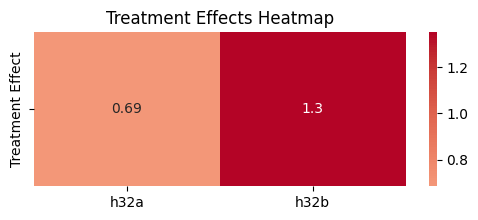

In [33]:
# Heatmap of treatment effects
treatment_effects = pd.DataFrame({
    'h32a': [results1.params['time1_group1']],
    'h32b': [results2.params['time2_group2']]
}, index=['Treatment Effect'])
plt.figure(figsize=(6, 2))
sns.heatmap(treatment_effects, annot=True, cmap='coolwarm', center=0)
plt.title('Treatment Effects Heatmap')
plt.show()

In [ ]:
# Print standard errors and p-values
print("=== h32a Standard Errors and p-values ===")
print(results1.bse)
print(results1.pvalues)
print("\n=== h32b Standard Errors and p-values ===")
print(results2.bse)
print(results2.pvalues)

=== h32a Standard Errors and p-values ===
const          0.031199
time1          0.044166
group1         0.044210
time1_group1   0.062522
dtype: float64
const          0.407566
time1          0.000000
group1         0.000000
time1_group1   0.000000
dtype: float64

=== h32b Standard Errors and p-values ===
const          0.073377
time2          0.103874
group2         0.103978
time2_group2   0.147047
dtype: float64
const          0.164369
time2          0.000000
group2         0.000000
time2_group2   0.000000
dtype: float64


# Reflection

In [39]:
after = h31["After"].astype(int)              # 1 at/after event, 0 before
time = h31["time"].astype(float)              # original time
time_squared = time ** 2                      # time^2
time_after = after * time                     # slope change after
time_after_squared = after * time_squared     # curvature change after

curvature_rows = []
for series_name in series_list:
    y = h31[series_name].astype(float).to_numpy()
    X = pd.DataFrame({
        "time": time,
        "time_squared": time_squared,
        "after": after,
        "time_after": time_after,
        "time_after_squared": time_after_squared
    })
    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()
    curvature_rows.append({
        "series": series_name,
        "time_after_squared_coef": float(model.params["time_after_squared"]),
        "time_after_squared_se": float(model.bse["time_after_squared"]),
        "time_after_squared_t": float(model.tvalues["time_after_squared"]),
        "time_after_squared_p": float(model.pvalues["time_after_squared"]),
        "second_derivative_jump": float(2 * model.params["time_after_squared"])
    })

curvature_results = pd.DataFrame(curvature_rows)
curvature_results["abs_time_after_squared_coef"] = curvature_results["time_after_squared_coef"].abs()
curvature_sorted = curvature_results.sort_values(
    by=["time_after_squared_p", "abs_time_after_squared_coef"],
    ascending=[True, False]
).reset_index(drop=True)

print("\n=== Change in 2nd derivative at time = 50 (value ~ const + time + time^2 + after + time_after + time_after^2) ===")
print(curvature_sorted[["series", "time_after_squared_coef", "time_after_squared_se",
                        "time_after_squared_t", "time_after_squared_p",
                        "second_derivative_jump"]].to_string(index=False))
print(f"\nStrongest curvature change: {curvature_sorted.loc[0, 'series']}")


=== Change in 2nd derivative at time = 50 (value ~ const + time + time^2 + after + time_after + time_after^2) ===
series  time_after_squared_coef  time_after_squared_se  time_after_squared_t  time_after_squared_p  second_derivative_jump
value2                 0.001596               0.001110              1.437893              0.153785                0.003193
value3                -0.000294               0.001029             -0.285971              0.775529               -0.000589
value1                 0.000027               0.001034              0.025997              0.979315                0.000054

Strongest curvature change: value2


In [71]:
# Basic settings
number_of_days = 1000
event_day = 500  # Dallas ends cashless bail here
slope_per_day = -0.01  # same downward trend in both cities
intercept_dallas = 20.0
intercept_fort_worth = 15.0
treatment_level_effect = -1.5  # extra drop in Dallas after the event

rows = []

# Build the panel for both cities
for city_name, city_intercept, is_treated in [
    ("Dallas", intercept_dallas, 1),
    ("Fort Worth", intercept_fort_worth, 0)
]:
    for day in range(number_of_days):
        is_post = 1 if day >= event_day else 0
        # Expected murders: parallel slopes, different intercepts, level drop after policy in Dallas
        murders = round(city_intercept + slope_per_day * day + is_treated * is_post * treatment_level_effect + np.random.normal(0, 2), 0)
        rows.append({
            "city": city_name,
            "day": day,
            "murders": murders,
            "treated": is_treated,  # Dallas=1, Fort Worth=0
            "post": is_post         # day >= 500 = 1
        })

# Final dataframe
did_data = pd.DataFrame(rows)

In [72]:
did_data

,city,day,murders,treated,post
0,Dallas,0,21.000000,1,0
1,Dallas,1,19.000000,1,0
2,Dallas,2,21.000000,1,0
3,Dallas,3,19.000000,1,0
4,Dallas,4,20.000000,1,0
...,...,...,...,...,...
1995,Fort Worth,995,6.000000,0,1
1996,Fort Worth,996,7.000000,0,1
1997,Fort Worth,997,8.000000,0,1
1998,Fort Worth,998,6.000000,0,1


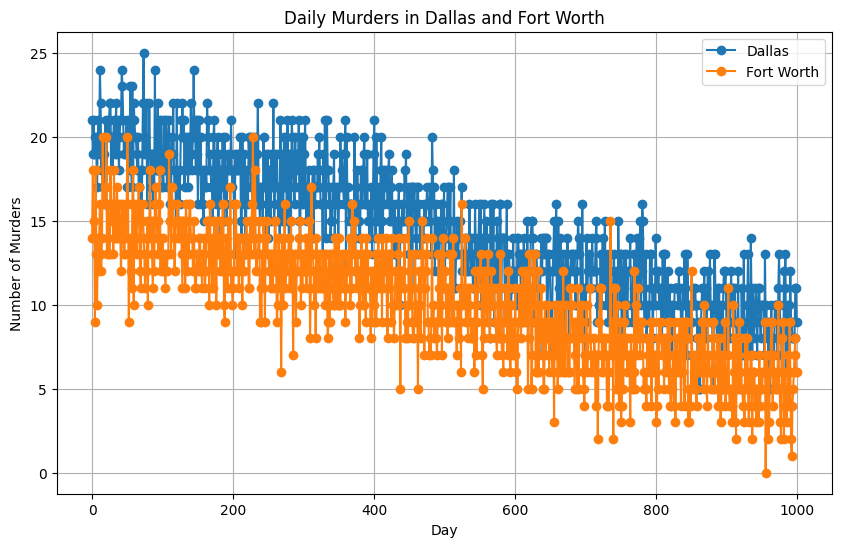

In [73]:
# Plot murders over time for both cities
plt.figure(figsize=(10, 6))
for city, group in did_data.groupby('city'):
    plt.plot(group['day'], group['murders'], label=city, marker='o')
plt.xlabel('Day')
plt.ylabel('Number of Murders')
plt.title('Daily Murders in Dallas and Fort Worth')
plt.legend()
plt.grid()
plt.show()

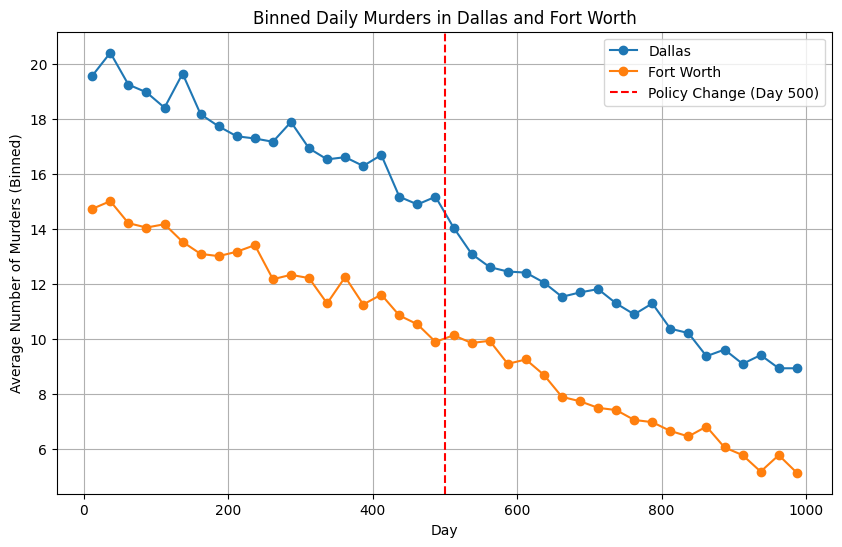

In [83]:
# Binned plot
bin_size = 25

plt.figure(figsize=(10, 6))
for city, group in did_data.groupby('city'):
    binned_days = group['day'].values.reshape(-1, bin_size).mean(axis=1)
    binned_murders = group['murders'].values.reshape(-1, bin_size).mean(axis=1)
    plt.plot(binned_days, binned_murders, label=city, marker='o')
plt.xlabel('Day')
plt.ylabel('Average Number of Murders (Binned)')
plt.title('Binned Daily Murders in Dallas and Fort Worth')
plt.axvline(event_day, color='red', linestyle='--', label='Policy Change (Day 500)')
plt.legend()
plt.grid()
plt.show()

In [75]:
# Regression for differences-in-differences
X = pd.DataFrame({
    "treated": did_data["treated"],
    "post": did_data["post"],
    "treated_post": did_data["treated"] * did_data["post"]
})
X = sm.add_constant(X)
y = did_data["murders"]
results = sm.OLS(y, X).fit()
print("=== Differences-in-Differences Regression Results ===")
print(results.params)
print("\nStandard Errors:")
print(results.bse)
print("\np-values:")
print(results.pvalues)

=== Differences-in-Differences Regression Results ===
const          12.628000
treated         4.870000
post           -5.174000
treated_post   -1.280000
dtype: float64

Standard Errors:
const          0.111272
treated        0.157363
post           0.157363
treated_post   0.222545
dtype: float64

p-values:
const          0.000000
treated        0.000000
post           0.000000
treated_post   0.000000
dtype: float64
